In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# Constants
LOOKUP_MIN = 0.01
FIXED_POINT_SCALE = 1 << 32  # 8-bit fixed-point scaling

# Taylor series-based approximation for log2
def taylor_log2(x, n_terms=3):
    """
    Approximate log2(x) using a Taylor series expansion for log2(1 + x).
    Args:
        x: Input tensor.
        n_terms: Number of terms in the Taylor series expansion.
    Returns:
        Approximated log2 values.
    """
    x_clipped = tf.clip_by_value(x, LOOKUP_MIN, 256.0)  # Clip to avoid invalid values
    exponent = tf.floor(tf.math.log(x_clipped) / tf.math.log(2.0))
    mantissa = x_clipped / tf.pow(2.0, exponent)
    mantissa_shifted = mantissa - 1.0

    log2_mantissa = 0
    for k in range(1, n_terms + 1):
        term = (-1) ** (k + 1) * tf.pow(mantissa_shifted, k) / (k * tf.math.log(2.0))
        log2_mantissa += term

    return exponent + log2_mantissa

# Fixed-point quantization with Taylor series
def log2_quantize(x, method="floor", fractional_bits=3):
    """
    Quantize log2(x) using Taylor series approximation.
    Args:
        x: Input tensor.
        method: Quantization method ('floor' or 'round').
        fractional_bits: Number of fractional bits for quantization.
    Returns:
        Quantized log2 representation.
    """
    log2_x = taylor_log2(x, n_terms=3)
    if method == "floor":
        return tf.floor(log2_x)
    elif method == "round":
        integer_part = tf.floor(log2_x)
        fractional_part = log2_x - integer_part
        threshold = (2**fractional_bits - 1) / (2**fractional_bits)
        return integer_part + tf.cast(fractional_part >= threshold, tf.float32)
    else:
        raise ValueError("Invalid quantization method. Choose 'floor' or 'round'.")

# Complex CNN with log2 quantization
class LogCNN(tf.keras.Model):
    def __init__(self, input_shape, num_classes):
        super(LogCNN, self).__init__()

        # First Block
        self.conv1 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.pool1 = layers.MaxPooling2D((2, 2))
        self.dropout1 = layers.Dropout(0.25)

        # Second Block
        self.conv3 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.bn2 = layers.BatchNormalization()
        self.conv4 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.pool2 = layers.MaxPooling2D((2, 2))
        self.dropout2 = layers.Dropout(0.25)

        # Third Block
        self.conv5 = layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.bn3 = layers.BatchNormalization()
        self.conv6 = layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.pool3 = layers.MaxPooling2D((2, 2))
        self.dropout3 = layers.Dropout(0.25)

        # Fully Connected Layers
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(512, activation='relu')
        self.bn4 = layers.BatchNormalization()
        self.dropout4 = layers.Dropout(0.5)
        self.fc2 = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        # Logarithmic quantization before each convolutional block
        x = log2_quantize(inputs, method="floor")
        x = self.conv1(x)
        x = self.bn1(x)

        x = log2_quantize(x, method="floor")
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = log2_quantize(x, method="floor")
        x = self.conv3(x)
        x = self.bn2(x)

        x = log2_quantize(x, method="floor")
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = log2_quantize(x, method="floor")
        x = self.conv5(x)
        x = self.bn3(x)

        x = log2_quantize(x, method="floor")
        x = self.conv6(x)
        x = self.pool3(x)
        x = self.dropout3(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn4(x)
        x = self.dropout4(x)
        x = self.fc2(x)

        return x

# Main Training and Evaluation Code
if __name__ == "__main__":
    # Load and preprocess MNIST data
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = x_train.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)

    # Resize to 32x32 to match larger input shape
    x_train = tf.image.resize(x_train, (32, 32))
    x_test = tf.image.resize(x_test, (32, 32))

    # One-hot encode the labels
    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)

    # Instantiate and compile the model
    input_shape = (32, 32, 1)
    num_classes = 10
    model = LogCNN(input_shape, num_classes)

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    # Train the model
    model.fit(x_train, y_train, batch_size=64, epochs=10, validation_split=0.1)

    # Evaluate on test data
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
    print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/10


C:\Users\prabh\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:735: UserWarning: Gradients do not exist for variables ['log_cnn/conv2d/kernel', 'log_cnn/conv2d/bias', 'log_cnn/batch_normalization/gamma', 'log_cnn/batch_normalization/beta', 'log_cnn/conv2d_1/kernel', 'log_cnn/conv2d_1/bias', 'log_cnn/conv2d_2/kernel', 'log_cnn/conv2d_2/bias', 'log_cnn/batch_normalization_1/gamma', 'log_cnn/batch_normalization_1/beta', 'log_cnn/conv2d_3/kernel', 'log_cnn/conv2d_3/bias', 'log_cnn/conv2d_4/kernel', 'log_cnn/conv2d_4/bias', 'log_cnn/batch_normalization_2/gamma', 'log_cnn/batch_normalization_2/beta'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


844/844 ━━━━━━━━━━━━━━━━━━━━ 113s 131ms/step - accuracy: 0.6359 - loss: 3.3912 - val_accuracy: 0.9323 - val_loss: 0.2109
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 118s 139ms/step - accuracy: 0.9306 - loss: 0.2098 - val_accuracy: 0.9438 - val_loss: 0.1733
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 117s 139ms/step - accuracy: 0.9448 - loss: 0.1677 - val_accuracy: 0.9588 - val_loss: 0.1314
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 117s 138ms/step - accuracy: 0.9567 - loss: 0.1306 - val_accuracy: 0.9573 - val_loss: 0.1367
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 117s 139ms/step - accuracy: 0.9587 - loss: 0.1227 - val_accuracy: 0.9570 - val_loss: 0.1366
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 116s 137ms/step - accuracy: 0.9619 - loss: 0.1134 - val_accuracy: 0.9588 - val_loss: 0.1347
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 118s 139ms/step - accuracy: 0.9668 - loss: 0.0996 - val_accuracy: 0.9520 - val_loss: 0.1552
Epoch 8/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 117s 138ms/step - accuracy: 0.9681 - loss: 0.09

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

lookup_min = 0.01
fixed_point_scale = 1 << 32

def taylor_approx(x, n_terms=3):
    x_clipped = tf.clip_by_value(x, lookup_min, 256.0)
    exponent = tf.floor(tf.math.log(x_clipped) / tf.math.log(2.0))
    mantissa = x_clipped / tf.pow(2.0, exponent)
    mantissa_shifted = mantissa - 1.0

    log2_mantissa = 0
    for k in range(1, n_terms + 1):
        term = (-1) ** (k + 1) * tf.pow(mantissa_shifted, k) / (k * tf.math.log(2.0))
        log2_mantissa += term

    return exponent + log2_mantissa

def log_quantize(x):
    log2_x = taylor_approx(x, n_terms=3)
    return tf.floor(log2_x)

class LogCNN(tf.keras.Model):
    def __init__(self, input_shape, num_classes):
        super(LogCNN, self).__init__()
        self.conv1 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.pool1 = layers.MaxPooling2D((2, 2))
        self.dropout1 = layers.Dropout(0.25)
        self.conv3 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.bn2 = layers.BatchNormalization()
        self.conv4 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.pool2 = layers.MaxPooling2D((2, 2))
        self.dropout2 = layers.Dropout(0.25)
        self.conv5 = layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.bn3 = layers.BatchNormalization()
        self.conv6 = layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.pool3 = layers.MaxPooling2D((2, 2))
        self.dropout3 = layers.Dropout(0.25)
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(512, activation='relu')
        self.bn4 = layers.BatchNormalization()
        self.dropout4 = layers.Dropout(0.5)
        self.fc2 = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = log_quantize(inputs)
        x = self.conv1(x)
        x = self.bn1(x)
        x = log_quantize(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        x = log_quantize(x)
        x = self.conv3(x)
        x = self.bn2(x)
        x = log_quantize(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        x = log_quantize(x)
        x = self.conv5(x)
        x = self.bn3(x)
        x = log_quantize(x)
        x = self.conv6(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn4(x)
        x = self.dropout4(x)
        x = self.fc2(x)
        return x

if __name__ == "__main__":
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = x_train.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)
    x_train = tf.image.resize(x_train, (32, 32))
    x_test = tf.image.resize(x_test, (32, 32))
    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)
    input_shape = (32, 32, 1)
    num_classes = 10
    model = LogCNN(input_shape, num_classes)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(x_train, y_train, batch_size=64, epochs=10, validation_split=0.1)
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
    print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/10


C:\Users\prabh\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:735: UserWarning: Gradients do not exist for variables ['log_cnn_1/conv2d_6/kernel', 'log_cnn_1/conv2d_6/bias', 'log_cnn_1/batch_normalization_4/gamma', 'log_cnn_1/batch_normalization_4/beta', 'log_cnn_1/conv2d_7/kernel', 'log_cnn_1/conv2d_7/bias', 'log_cnn_1/conv2d_8/kernel', 'log_cnn_1/conv2d_8/bias', 'log_cnn_1/batch_normalization_5/gamma', 'log_cnn_1/batch_normalization_5/beta', 'log_cnn_1/conv2d_9/kernel', 'log_cnn_1/conv2d_9/bias', 'log_cnn_1/conv2d_10/kernel', 'log_cnn_1/conv2d_10/bias', 'log_cnn_1/batch_normalization_6/gamma', 'log_cnn_1/batch_normalization_6/beta'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


844/844 ━━━━━━━━━━━━━━━━━━━━ 112s 127ms/step - accuracy: 0.6368 - loss: 3.0162 - val_accuracy: 0.9213 - val_loss: 0.2458
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 113s 134ms/step - accuracy: 0.9223 - loss: 0.2379 - val_accuracy: 0.9320 - val_loss: 0.2224
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 110s 131ms/step - accuracy: 0.9414 - loss: 0.1790 - val_accuracy: 0.9508 - val_loss: 0.1570
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 111s 131ms/step - accuracy: 0.9518 - loss: 0.1451 - val_accuracy: 0.9485 - val_loss: 0.1646
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 110s 130ms/step - accuracy: 0.9560 - loss: 0.1299 - val_accuracy: 0.9538 - val_loss: 0.1493
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 110s 131ms/step - accuracy: 0.9602 - loss: 0.1198 - val_accuracy: 0.9432 - val_loss: 0.1828
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 112s 132ms/step - accuracy: 0.9621 - loss: 0.1159 - val_accuracy: 0.9538 - val_loss: 0.1429
Epoch 8/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 112s 133ms/step - accuracy: 0.9630 - loss: 0.10

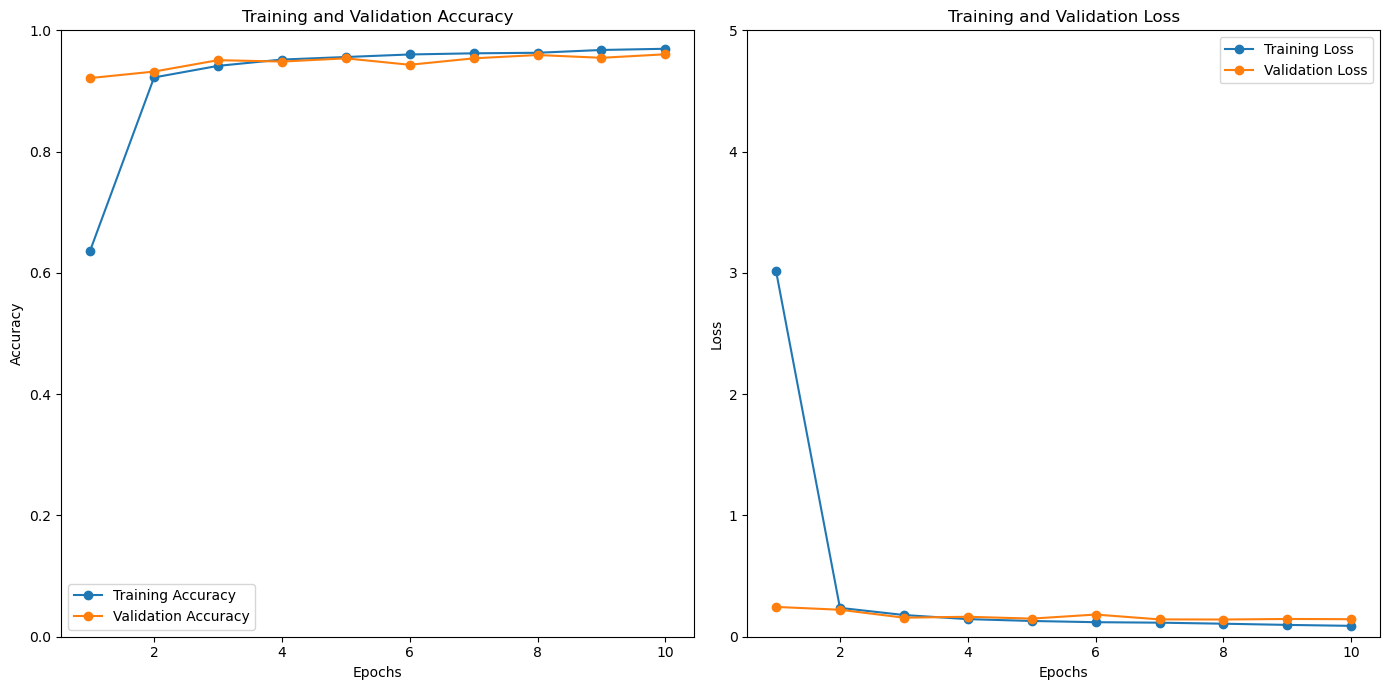

In [1]:
import matplotlib.pyplot as plt

# Training and validation metrics
accuracy = [0.6368, 0.9223, 0.9414, 0.9518, 0.9560, 0.9602, 0.9621, 0.9630, 0.9676, 0.9696]
val_accuracy = [0.9213, 0.9320, 0.9508, 0.9485, 0.9538, 0.9432, 0.9538, 0.9593, 0.9547, 0.9605]
loss = [3.0162, 0.2379, 0.1790, 0.1451, 0.1299, 0.1198, 0.1159, 0.1073, 0.0975, 0.0896]
val_loss = [0.2458, 0.2224, 0.1570, 0.1646, 0.1493, 0.1828, 0.1429, 0.1419, 0.1465, 0.1445]

# Number of epochs
epochs = range(1, 11)

# Plotting accuracy
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.0, 1.0)  # Scale for accuracy
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0.0, 5.0)  # Scale for loss
plt.legend()

plt.tight_layout()
plt.show()


In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

lookup_min = 0.01
fixed_point_scale = 1 << 32

# Precompute lookup table for log2 values
def create_lookup_table():
    lookup_values = np.log2(np.linspace(lookup_min, 256.0, 1024))
    return tf.constant(lookup_values, dtype=tf.float32)

lookup_table = create_lookup_table()

# Optimized taylor_approx using lookup table
def taylor_approx(x):
    x_clipped = tf.clip_by_value(x, lookup_min, 256.0)
    indices = tf.cast((x_clipped - lookup_min) / (256.0 - lookup_min) * 1023, tf.int32)
    return tf.gather(lookup_table, indices)

def log_quantize(x):
    log2_x = taylor_approx(x)
    return tf.floor(log2_x)

class LogCNN(tf.keras.Model):
    def __init__(self, input_shape, num_classes):
        super(LogCNN, self).__init__()
        self.conv1 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')
        self.pool1 = layers.MaxPooling2D((2, 2))
        self.dropout1 = layers.Dropout(0.25)
        self.conv3 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.bn2 = layers.BatchNormalization()
        self.conv4 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')
        self.pool2 = layers.MaxPooling2D((2, 2))
        self.dropout2 = layers.Dropout(0.25)
        self.conv5 = layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.bn3 = layers.BatchNormalization()
        self.conv6 = layers.Conv2D(256, (3, 3), padding='same', activation='relu')
        self.pool3 = layers.MaxPooling2D((2, 2))
        self.dropout3 = layers.Dropout(0.25)
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(512, activation='relu')
        self.bn4 = layers.BatchNormalization()
        self.dropout4 = layers.Dropout(0.5)
        self.fc2 = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = log_quantize(inputs)
        x = self.conv1(x)
        x = self.bn1(x)
        x = log_quantize(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        x = log_quantize(x)
        x = self.conv3(x)
        x = self.bn2(x)
        x = log_quantize(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        x = log_quantize(x)
        x = self.conv5(x)
        x = self.bn3(x)
        x = log_quantize(x)
        x = self.conv6(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn4(x)
        x = self.dropout4(x)
        x = self.fc2(x)
        return x

if __name__ == "__main__":
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = x_train.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)
    x_train = tf.image.resize(x_train, (32, 32))
    x_test = tf.image.resize(x_test, (32, 32))
    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)
    input_shape = (32, 32, 1)
    num_classes = 10
    model = LogCNN(input_shape, num_classes)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    model.fit(x_train, y_train, batch_size=64, epochs=10, validation_split=0.1)
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
    print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/10


C:\Users\prabh\anaconda3\Lib\site-packages\keras\src\optimizers\base_optimizer.py:735: UserWarning: Gradients do not exist for variables ['log_cnn/conv2d/kernel', 'log_cnn/conv2d/bias', 'log_cnn/batch_normalization/gamma', 'log_cnn/batch_normalization/beta', 'log_cnn/conv2d_1/kernel', 'log_cnn/conv2d_1/bias', 'log_cnn/conv2d_2/kernel', 'log_cnn/conv2d_2/bias', 'log_cnn/batch_normalization_1/gamma', 'log_cnn/batch_normalization_1/beta', 'log_cnn/conv2d_3/kernel', 'log_cnn/conv2d_3/bias', 'log_cnn/conv2d_4/kernel', 'log_cnn/conv2d_4/bias', 'log_cnn/batch_normalization_2/gamma', 'log_cnn/batch_normalization_2/beta'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


844/844 ━━━━━━━━━━━━━━━━━━━━ 62s 72ms/step - accuracy: 0.5767 - loss: 3.1528 - val_accuracy: 0.8912 - val_loss: 0.3275
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 66s 78ms/step - accuracy: 0.8835 - loss: 0.3493 - val_accuracy: 0.9090 - val_loss: 0.2730
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 66s 78ms/step - accuracy: 0.9012 - loss: 0.2932 - val_accuracy: 0.9015 - val_loss: 0.2960
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 69s 82ms/step - accuracy: 0.9081 - loss: 0.2695 - val_accuracy: 0.9130 - val_loss: 0.2602
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 85s 101ms/step - accuracy: 0.9144 - loss: 0.2560 - val_accuracy: 0.9157 - val_loss: 0.2564
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 112s 133ms/step - accuracy: 0.9179 - loss: 0.2434 - val_accuracy: 0.9180 - val_loss: 0.2580
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 112s 133ms/step - accuracy: 0.9207 - loss: 0.2329 - val_accuracy: 0.9138 - val_loss: 0.2532
Epoch 8/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 114s 135ms/step - accuracy: 0.9239 - loss: 0.2269 - val_

In [25]:
import numpy as np

# Constants
lookup_min = 0.01
lookup_max = 256.0
lookup_size = 1024
fixed_point_bits = 16  # Number of bits for fixed-point representation

def generate_lookup_table():
    """
    Generate a lookup table for log2 values and convert to fixed-point representation.
    Returns:
        A list of fixed-point integers representing log2 values.
    """
    # Compute log2 values in the given range
    lookup_values = np.log2(np.linspace(lookup_min, lookup_max, lookup_size))

    # Convert to fixed-point representation
    scale_factor = 2 ** (fixed_point_bits - 1)  # Fixed-point scaling factor
    fixed_point_values = (lookup_values * scale_factor).astype(int)

    return fixed_point_values

# Generate the lookup table
lookup_table = generate_lookup_table()

# Print the lookup table values
print("-- Log2 Lookup Table (Fixed-Point Representation) --")
for i, value in enumerate(lookup_table):
    print(f"{value},")


-- Log2 Lookup Table (Fixed-Point Representation) --
-217705,
-63639,
-31788,
-12930,
514,
10969,
19526,
26768,
33047,
38589,
43549,
48038,
52137,
55909,
59402,
62655,
65698,
68557,
71253,
73803,
76223,
78525,
80720,
82818,
84827,
86753,
88604,
90386,
92103,
93759,
95360,
96908,
98407,
99860,
101269,
102638,
103968,
105262,
106522,
107748,
108944,
110110,
111248,
112360,
113445,
114507,
115545,
116561,
117555,
118529,
119483,
120419,
121336,
122236,
123119,
123986,
124837,
125673,
126495,
127302,
128096,
128877,
129645,
130401,
131145,
131878,
132599,
133310,
134010,
134699,
135379,
136049,
136710,
137362,
138005,
138639,
139265,
139882,
140492,
141094,
141688,
142275,
142855,
143428,
143994,
144553,
145106,
145652,
146192,
146726,
147254,
147776,
148292,
148803,
149309,
149809,
150304,
150793,
151278,
151758,
152233,
152703,
153168,
153629,
154086,
154538,
154986,
155430,
155869,
156305,
156737,
157164,
157588,
158008,
158425,
158837,
159246,
159652,
160054,
160453,
160849,
161241,
16